In [ ]:
## for two images

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
import numpy as np
from keras_vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
import keras
import unittest
import time
import os
from tqdm import tqdm
import random

def cos_similar(a, b):
    A = np.array(a)
    B = np.array(b)
    
    num = np.sum(A*B)
    denom = np.linalg.norm(A) * np.linalg.norm(B)  
    
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    
    return sim

model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

result = {}
total = 0
threshold = 0.86
error = 0
error_names = []
test_num = 90

batch_size = 50
batches = 10

img1_path = "/home/thetensortec/TestDataSet_chip_mtcnn/TestDataSet_5/TestDataSet_5_scale_0.3/michael/149.jpg_chip.png"
img2_path = "/home/thetensortec/TestDataSet_chip_mtcnn/TestDataSet_2/TestDataSet_2_scale_0.3/michael/150.jpg_chip.png"

img1 = image.load_img(img1_path, target_size=(224, 224))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x1 = utils.preprocess_input(x1, version=2)

img2 = image.load_img(img2_path, target_size=(224, 224))
x2 = image.img_to_array(img2)
x2 = np.expand_dims(x2, axis=0)
x2 = utils.preprocess_input(x2, version=2)

preds_1 = model.predict(x1)
preds_2 = model.predict(x2)


preds_2 = np.array(preds_2)
preds_2 = preds_2.reshape(2048)
preds_1 = np.array(preds_1)
preds_1 = preds_1.reshape(2048)

similar = 1/(1+np.linalg.norm(preds_1-preds_2))
cos = cos_similar(preds_1, preds_2)

print ("Similar is {}, between {} and {}".format(cos, img1_path, img2_path))

In [ ]:
## for same person

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
import numpy as np
from keras_vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
import keras
import unittest
import time
import os
from tqdm import tqdm
import random

def cos_similar(a, b):
    A = np.array(a)
    B = np.array(b)
    
    num = np.sum(A*B)
    denom = np.linalg.norm(A) * np.linalg.norm(B)  
    
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    
    return sim

model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
log_file_name = "SamePerson_" +  name + "_margin_" + str(threshold) + "_scale_" + scale + ".log"

test_data_path = "/home/thetensortec/TestDataSet_chip_mtcnn/TestDataSet_Total/TestDataSet_Total_scale_0.3"

data_dirs = os.listdir(test_data_path)

In [ ]:

result = {}
total = 0
error = 0
error_names = []
test_num = 90
error_similar_same = []
error_similar_diff = []



batch_size = 64
name = 'zhaohuiwu'
scale = '0.3'
threshold = 0.8
#thresholds = [0.78, 0.79, 0.80, 0.81, 0.82]

log_file_name = "SamePerson_" +  name + "_margin_" + str(threshold) + "_scale_" + scale + ".log"
test_data_path = "/home/thetensortec/TestDataSet_chip_mtcnn/SamePerson/" + name + "/" + scale + "/"

data_dirs = os.listdir(test_data_path)
#data_dirs = ['TestDataSet_1', 'TestDataSet_2']
## get all vectors
data_vectors = {}
dir_files = {}

def cos_similar(a, b):
    A = np.array(a)
    B = np.array(b)
    
    num = np.sum(A*B)
    denom = np.linalg.norm(A) * np.linalg.norm(B)  
    
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    
    return sim

for data_dir in data_dirs:
    files = os.listdir(test_data_path + data_dir)
    np.random.shuffle(files)
    #files = files[:244]
    dir_files[data_dir] = files
    ## read images
    #print ("Loading...")
    imgs = []
    for file in files:
        file_path = test_data_path + data_dir + '/' + file
        img = image.load_img(file_path, target_size=(224, 224))
        img = image.img_to_array(img)
        imgs.append(img)

    ## predict
    #print ("Predicting...")
    vectors = []
    for batch_start in np.arange(0, len(files), batch_size):
        batch_end = batch_start + batch_size

        if batch_end > len(files):
            batch_end = len(files)
        #print ("Start {}, End {}".format(batch_start, batch_end))
        imgs_prepro = utils.preprocess_input(imgs[batch_start:batch_end], version=2)
        imgs_predicts = model.predict(imgs_prepro)

        vectors.extend(imgs_predicts)

    data_vectors[data_dir] = vectors

## compare all dirs
#print ("Comparing...")
all_similars = {}
error_count = {}
dirs_error_count = {}
with open(log_file_name, "w") as fo:
    for index1 in range(len(data_dirs)):
        for index2 in range(index1 + 1, len(data_dirs)):
            ## compare two dirs
            similars = []

            sub_total = 0
            sub_error = 0

            name1 = data_dirs[index1]
            name2 = data_dirs[index2]

            vectors1 = data_vectors[name1]
            vectors2 = data_vectors[name2]

            for vec1_index, vec1 in enumerate(vectors1):
                for vec2_index, vec2 in enumerate(vectors2):
                    cos = cos_similar(vec1, vec2)
                    similars.append(cos)
                    
                    sub_total += 1

                    if cos < threshold:
                        sub_error += 1
                        
                        ## error count
                        if name1 not in error_count.keys():
                            error_count[name1] = {}
                        if dir_files[name1][vec1_index] not in error_count[name1].keys():
                            error_count[name1][dir_files[name1][vec1_index]] = 0
                        if name1 + '/' + dir_files[name1][vec1_index] not in dirs_error_count.keys():
                            dirs_error_count[name1 + '/' + dir_files[name1][vec1_index]] = 0
                        
                        if name2 not in error_count.keys():
                            error_count[name2] = {}
                        if dir_files[name2][vec2_index] not in error_count[name2].keys():
                            error_count[name2][dir_files[name2][vec2_index]] = 0
                        if name2 + '/' + dir_files[name2][vec2_index] not in dirs_error_count.keys():
                            dirs_error_count[name2 + '/' + dir_files[name2][vec2_index]] = 0                            
                            
                        error_count[name1][dir_files[name1][vec1_index]] += 1
                        error_count[name2][dir_files[name2][vec2_index]] += 1
                        
                        dirs_error_count[name1 + '/' + dir_files[name1][vec1_index]] += 1
                        dirs_error_count[name2 + '/' + dir_files[name2][vec2_index]] += 1
                        
                        log = "similar {}, {} --> {}".format(cos, name1 + '/' + dir_files[name1][vec1_index], name2 + '/' + dir_files[name2][vec2_index])
                        fo.write(log+'\n')
                        
            #log = "{} and {} Total compare {}, error {}, accuracy {}%".format(name1, name2, sub_total, sub_error, round(((sub_total-sub_error)/sub_total)*100, 2))
            #print (log)
            #fo.write(log+'\n')
            all_similars[name1+'_'+name2] = similars

            total += sub_total
            error += sub_error

    log = "{} scale {} threshold {} Total num:{}, Errors:{}, Accuracy:{}%".format(name, scale, threshold, total, error, round(((total-error)/total)*100, 2))
    fo.write(log)
    print (log)
    print ('\n')
    #    for log in error_names:
    #        fo.write(log+'\n')
    

In [ ]:
top = 50

print ("LOG FILE: {}".format(log_file_name))

for key_dir in error_count.keys():
    dis = sorted(error_count[key_dir].items(),key = lambda x:x[1],reverse = True)
    print ("{} top {}".format(key_dir, top))
    print (dis[:top])


dis = sorted(dirs_error_count.items(),key = lambda x:x[1],reverse = True)
print ("All top {}".format(top))
for item in dis[:top]:
    print (item)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

data = np.random.randn(10000)

#title = "euclidean"
title = "cos_similar"
name2 = "qiuyifan"
name1 = "fuxiaotian"

#print ("Total num:{}, Errors:{}, Accuracy:{}%".format(total, error, round(((total-error)/total)*100, 2)))
#print (error_names[:10])

tmp = np.array(list(all_similars.keys()))

plt.hist(all_similars[tmp[0]], bins=100, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
#plt.hist(cos_similars, bins=100, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("range")
# 显示纵轴标签
plt.ylabel("rate")
# 显示图标题
plt.title("{} {} (scale {}, threshold {}) : {}".format(name, title, scale, threshold, tmp))
plt.show()

In [ ]:
## for many persones

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
import numpy as np
from keras_vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
import keras
import unittest
import time
import os
from tqdm import tqdm
import random

def cos_similar(a, b):
    A = np.array(a)
    B = np.array(b)
    
    num = np.sum(A*B, axis=1)
    denom = np.linalg.norm(A, axis=1) * np.linalg.norm(B, axis=1)  
    
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    
    return sim

model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
# 

result = {}
total = 0
error = 0
error_names = []
test_num = 90
error_similar_same = []
error_similar_diff = []

batch_size = 50
batches = 9

dataset = 'Wild'
threshold = 0.81
scale = '0.2'


log_file_name = "TestDataSet_" +  dataset + "_margin_" + str(threshold) + "_scale_" + scale + ".log"
test_data_path = "/home/thetensortec/TestDataSet_chip_mtcnn/TestDataSet_" +dataset+ "/TestDataSet_" +dataset+ "_scale_" + scale + "/"

names = os.listdir(test_data_path)

for index1 in range(len(names)):
    sub_result = {}
    result[names[index1]] = sub_result
    
    for index2 in range(index1 + 1):
        path1 = test_data_path + names[index1] + "/"
        path2 = test_data_path + names[index2] + "/"

        files1 = os.listdir(path1)
        files2 = os.listdir(path2)
        
        #print (path1)
        #print ("files1 num {}, files2 {}".format(len(files1), len(files2)))
        random.shuffle(files1)
        random.shuffle(files2)

        similars = []
        cos_similars = []
        peple_error_names = []
        peple_preds1 = []
        peple_preds2 = []
        result[names[index1]][names[index2]] = {}

        for batch in range(batches):
            time_start = time.time()
            start = batch * batch_size
            end = (batch + 1) * batch_size
            # read batch files
            imgs_1 = np.zeros((batch_size, 224, 224, 3))
            imgs_2 = np.zeros((batch_size, 224, 224, 3))
            
            for index in range(start, end):
                img1 = image.load_img(path1+files1[index], target_size=(224, 224))
                x1 = image.img_to_array(img1)
                imgs_1[index - batch*batch_size] = x1
                
                img2 = image.load_img(path2+files2[index], target_size=(224, 224))
                x2 = image.img_to_array(img2)
                imgs_2[index - batch*batch_size] = x2
            
            # preprocessing and predict
            imgs_1 = utils.preprocess_input(imgs_1, version=2)
            preds_1 = model.predict(imgs_1)
            
            imgs_2 = utils.preprocess_input(imgs_2, version=2)
            preds_2 = model.predict(imgs_2)
            
            time_end = time.time()
            
            # append the similarity
            peple_preds1.extend(preds_1)
            peple_preds2.extend(preds_2)
            
        # calculate distance
        assert(len(peple_preds1) == batch_size*batches)
        
        peple_preds_len = len(peple_preds1)
        shift_preds1 = np.array(peple_preds1)
        
        for shift_b in range(peple_preds_len):
            if shift_b == 0:
                shift_preds2 = np.array(peple_preds2)
            else:
                shift_preds2 = np.append(peple_preds2[peple_preds_len-shift_b:][0:shift_b], peple_preds2[:peple_preds_len-shift_b], axis=0)

            similar = 1/(1+np.linalg.norm(shift_preds1-shift_preds2, axis=1))
            cos = cos_similar(shift_preds1, shift_preds2)

            similars.extend(similar)
            cos_similars.extend(cos)

            total += peple_preds_len

            index_array_a = np.array(np.arange(0, peple_preds_len))
            index_array_b = np.array(np.arange(0, peple_preds_len))
            index_array_b = np.append(index_array_b[len(index_array_b)-shift_b:][0:shift_b], index_array_b[:len(index_array_b)-shift_b])

            for check_index in range(len(cos)):
                if cos[check_index] >= threshold: # same person
                    if index1 != index2:
                        error += 1
                        error_message = "{} -->  {}, similar:{}".format(names[index1] + "/" +files1[index_array_a[check_index]], names[index2] + "/" +files2[index_array_b[check_index]], cos[check_index])
                        error_names.append(error_message)
                        peple_error_names.append(error_message)
                        error_similar_diff.append(cos[check_index])
                else:
                    if index1 == index2:
                        error += 1
                        error_message = "{} -->  {}, similar:{}".format(names[index1] + "/"+files1[index_array_a[check_index]], names[index2] + "/"+files2[index_array_b[check_index]], cos[check_index])
                        error_names.append(error_message)
                        peple_error_names.append(error_message)
                        error_similar_same.append(cos[check_index])
            #print ("Batch size:{}  time cost:{} ms".format(batch_size, (time_end-time_start)*1000))
            
        similars = np.array(similars)
        cos_similars = np.array(cos_similars)
        peple_error_names = np.array(peple_error_names)
        
        print ("{} and {} has compared {} times".format(names[index1], names[index2], len(similars)))
        #print ("min:{} max:{} mean:{}".format(similars.min(), similars.max(), similars.mean()))
        #print ("min:{} max:{} mean:{}".format(cos_similars.min(), cos_similars.max(), cos_similars.mean()))
        
        result[names[index1]][names[index2]]["euclidean"] = similars
        result[names[index1]][names[index2]]["cos_similar"] = cos_similars
        result[names[index1]][names[index2]]["error_names"] = peple_error_names
        
        #print ("{} --> {}".format(names[index1], names[index2]))

with open(log_file_name, "w") as fo:
    for log in error_names:
        fo.write(log+'\n')
    fo.write("Total num:{}, Errors:{}, Accuracy:{}%".format(total, error, round(((total-error)/total)*100, 2)))

In [ ]:
## Overlaping Count

title = "cos_similar"
name1 = ''
name2 = ''

for name1 in result.keys():
    for name2 in result[name1].keys():

        positive = np.array(result[name1][name1][title])
        negative = np.array(result[name1][name2][title])

        min_val = min(positive)
        max_val = max(negative)

        print ("min:{} max:{}".format(min_val, max_val))
        #print (((positive>min_val) & (positive < max_val)).sum())

        positive_overlap_count = ((positive >= min_val) & (positive <= max_val)).sum()
        negative_overlap_count = ((negative >= min_val) & (negative <= max_val)).sum()

        print ("Between {} and {}, Total count {}, Overlap count {}".format(name1, name4, len(positive)+len(negative), positive_overlap_count+negative_overlap_count))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

data = np.random.randn(10000)

#title = "euclidean"
title = "cos_similar"
name2 = "qiuyifan"
name1 = "fuxiaotian"

print ("Total num:{}, Errors:{}, Accuracy:{}%".format(total, error, round(((total-error)/total)*100, 2)))

#print (error_names[:10])

plt.hist(result[name1][name2][title], bins=100, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
#plt.hist(cos_similars, bins=100, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("range")
# 显示纵轴标签
plt.ylabel("rate")
# 显示图标题
plt.title("{} : {} and {}".format(title, name1, name2))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

data = np.random.randn(10000)

#title = "euclidean"
title = "cos_similar"
name1 = "wangmengmeng"
name2 = "wangmengmeng"
name3 = "wangmengmeng"
name4 = "fuxiaotian"

plt.hist(result[name1][name2][title], bins=25, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(result[name3][name4][title], bins=25, normed=0, facecolor="red", edgecolor="red", alpha=0.7)
#plt.hist(cos_similars, bins=100, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("Similarity")
# 显示纵轴标签
plt.ylabel("Numbers")
# 显示图标题
plt.title("Red:{} vs {}        Blue:{} vs {}".format(name3, name4, name1, name2))
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

# tensorflow
model = VGGFace(model='resnet50', input_shape=(224, 224, 3))

# Change the image path with yours.
img = image.load_img('image/ajb.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # or version=2
preds = model.predict(x)
print('Predicted:', utils.decode_predictions(preds))

In [ ]:
## for many persones

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace
import numpy as np
from keras_vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
import keras
import unittest
import time
import os
from tqdm import tqdm
import random

def cos_similar(a, b):
    A = np.array(a)
    B = np.array(b)
    
    num = np.sum(A*B, axis=1)
    denom = np.linalg.norm(A, axis=1) * np.linalg.norm(B, axis=1)  
    
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    
    return sim

model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
import time

FF_result = []

for threshold in [0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85]:
    start = time.time()

    ## For ROC line
    result = {}
    total = 0
    error = 0
    error_names = []
    test_num = 90
    error_similar_same = []
    error_similar_diff = []

    ROC_count = {}
    ROC_count['diff_error'] = 0
    ROC_count['same_error'] = 0
    ## total = total_same_count + total_diff_count
    ROC_count['total'] = 0
    ROC_count['total_same_count'] = 0
    ROC_count['total_diff_count'] = 0

    batch_size = 70
    batches = 2

    log_file_name = str(threshold) + "_Roc.log"
    test_data_path = '/home/thetensortec/TestDataSet_chip_mtcnn/TestDataSet_Total/TestDataSet_Total_scale_0.3/'

    names = os.listdir(test_data_path)

    for index1 in range(len(names)):
        sub_result = {}
        result[names[index1]] = sub_result

        for index2 in range(index1 + 1):
            path1 = test_data_path + names[index1] + "/"
            path2 = test_data_path + names[index2] + "/"

            files1 = os.listdir(path1)
            files2 = os.listdir(path2)

            #print (path1)
            #print ("files1 num {}, files2 {}".format(len(files1), len(files2)))
            random.shuffle(files1)
            random.shuffle(files2)

            similars = []
            cos_similars = []
            peple_error_names = []
            peple_preds1 = []
            peple_preds2 = []
            result[names[index1]][names[index2]] = {}

            for batch in range(batches):
                time_start = time.time()
                start = batch * batch_size
                end = (batch + 1) * batch_size
                # read batch files
                imgs_1 = np.zeros((batch_size, 224, 224, 3))
                imgs_2 = np.zeros((batch_size, 224, 224, 3))

                for index in range(start, end):
                    img1 = image.load_img(path1+files1[index], target_size=(224, 224))
                    x1 = image.img_to_array(img1)
                    imgs_1[index - batch*batch_size] = x1

                    img2 = image.load_img(path2+files2[index], target_size=(224, 224))
                    x2 = image.img_to_array(img2)
                    imgs_2[index - batch*batch_size] = x2

                # preprocessing and predict
                imgs_1 = utils.preprocess_input(imgs_1, version=2)
                preds_1 = model.predict(imgs_1)

                imgs_2 = utils.preprocess_input(imgs_2, version=2)
                preds_2 = model.predict(imgs_2)

                time_end = time.time()

                # append the similarity
                peple_preds1.extend(preds_1)
                peple_preds2.extend(preds_2)

            # calculate distance
            assert(len(peple_preds1) == batch_size*batches)

            peple_preds_len = len(peple_preds1)
            shift_preds1 = np.array(peple_preds1)

            for shift_b in range(peple_preds_len):
                if shift_b == 0:
                    shift_preds2 = np.array(peple_preds2)
                else:
                    shift_preds2 = np.append(peple_preds2[peple_preds_len-shift_b:][0:shift_b], peple_preds2[:peple_preds_len-shift_b], axis=0)

                similar = 1/(1+np.linalg.norm(shift_preds1-shift_preds2, axis=1))
                cos = cos_similar(shift_preds1, shift_preds2)

                similars.extend(similar)
                cos_similars.extend(cos)

                total += peple_preds_len
                ROC_count['total'] += peple_preds_len

                if index1 == index2:
                    ROC_count['total_same_count'] += peple_preds_len
                else:
                    ROC_count['total_diff_count'] += peple_preds_len

                index_array_a = np.array(np.arange(0, peple_preds_len))
                index_array_b = np.array(np.arange(0, peple_preds_len))
                index_array_b = np.append(index_array_b[len(index_array_b)-shift_b:][0:shift_b], index_array_b[:len(index_array_b)-shift_b])

                for check_index in range(len(cos)):
                    if cos[check_index] >= threshold: # same person
                        if index1 != index2:
                            error += 1
                            error_message = "{} -->  {}, similar:{}".format(names[index1] + "/" +files1[index_array_a[check_index]], names[index2] + "/" +files2[index_array_b[check_index]], cos[check_index])
                            error_names.append(error_message)
                            peple_error_names.append(error_message)
                            error_similar_diff.append(cos[check_index])
                            ROC_count['diff_error'] += 1
                    else:
                        if index1 == index2:
                            error += 1
                            error_message = "{} -->  {}, similar:{}".format(names[index1] + "/"+files1[index_array_a[check_index]], names[index2] + "/"+files2[index_array_b[check_index]], cos[check_index])
                            error_names.append(error_message)
                            peple_error_names.append(error_message)
                            error_similar_same.append(cos[check_index])
                            ROC_count['same_error'] += 1
                #print ("Batch size:{}  time cost:{} ms".format(batch_size, (time_end-time_start)*1000))

            similars = np.array(similars)
            cos_similars = np.array(cos_similars)
            peple_error_names = np.array(peple_error_names)

            print ("{} and {} has compared {} times".format(names[index1], names[index2], len(similars)))
            #print ("min:{} max:{} mean:{}".format(similars.min(), similars.max(), similars.mean()))
            #print ("min:{} max:{} mean:{}".format(cos_similars.min(), cos_similars.max(), cos_similars.mean()))

            result[names[index1]][names[index2]]["euclidean"] = similars
            result[names[index1]][names[index2]]["cos_similar"] = cos_similars
            result[names[index1]][names[index2]]["error_names"] = peple_error_names

            #print ("{} --> {}".format(names[index1], names[index2]))

    end = time.time()

    assert(ROC_count['total'] == ROC_count['total_same_count'] + ROC_count['total_diff_count'])

    FAR = ROC_count['diff_error'] / ROC_count['total_diff_count']
    FRR = ROC_count['same_error'] / ROC_count['total_same_count']
    
    FF_result.append((threshold, FAR, FRR))
    
    with open(log_file_name, "w") as fo:
        fo.write("{}s, FAR {}, FRR {}, Total {}, Different Count {}, Same Count {}, Different Error {}, Same Error {}".format(end-start, FAR, FRR, ROC_count['total'], ROC_count['total_diff_count'], ROC_count['total_same_count'], ROC_count['diff_error'], ROC_count['same_error']))

    print ("{}s, FAR {}, FRR {},Total {}, Different Count {}, Same Count {}, Different Error {}, Same Error {}".format(end-start, FAR, FRR, ROC_count['total'], ROC_count['total_diff_count'], ROC_count['total_same_count'], ROC_count['diff_error'], ROC_count['same_error']))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

show = np.array([[1.42977648e-01, 1.36054422e-03],
                 [9.70626822e-02, 3.04761905e-03],
                 [6.11205053e-02, 5.74149660e-03],
                 [3.45947522e-02, 9.93877551e-03],
                 [1.72065112e-02, 1.60068027e-02],
                 [7.53935860e-03, 2.47551020e-02],
                 [3.05053450e-03, 3.45374150e-02],
                 [1.33916424e-03, 4.52789116e-02],
                 [5.68999028e-04, 5.69183673e-02],
                 [1.89504373e-04, 7.03129252e-02],
                 [4.32458698e-05, 8.75442177e-02]])

ROC = np.array([[x[0], x[1]] for x in show])
print (ROC)
plt.plot(ROC[:, 1], ROC[:, 0], marker = "o" ,mec = "k" , mfc = "b", mew = 0.5)
plt.plot(ROC[:, 1]+0.03, ROC[:, 0]+0.03, marker = "o" ,mec = "k" , mfc = "b", mew = 0.5)

plt.ylabel('FAR')
plt.xlabel('FRR')
plt.title("ROC")
plt.show()
import matplotlib.pyplot as plt
import numpy as np

show = np.array([[1.42977648e-01, 1.36054422e-03],
                 [9.70626822e-02, 3.04761905e-03],
                 [6.11205053e-02, 5.74149660e-03],
                 [3.45947522e-02, 9.93877551e-03],
                 [1.72065112e-02, 1.60068027e-02],
                 [7.53935860e-03, 2.47551020e-02],
                 [3.05053450e-03, 3.45374150e-02],
                 [1.33916424e-03, 4.52789116e-02],
                 [5.68999028e-04, 5.69183673e-02],
                 [1.89504373e-04, 7.03129252e-02],
                 [4.32458698e-05, 8.75442177e-02]])

ROC = np.array([[x[0], x[1]] for x in show])
print (ROC)
plt.plot(ROC[:, 1], ROC[:, 0], marker = "o" ,mec = "k" , mfc = "b", mew = 0.5)
plt.plot(ROC[:, 1]+0.03, ROC[:, 0]+0.03, marker = "o" ,mec = "k" , mfc = "b", mew = 0.5)

plt.ylabel('FAR')
plt.xlabel('FRR')
plt.title("ROC")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

VGG_show = np.array([[1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [1.42977648e-01, 1.36054422e-03],
                    [9.70626822e-02, 3.04761905e-03],
                    [6.11205053e-02, 5.74149660e-03],
                    [3.45947522e-02, 9.93877551e-03],
                    [1.72065112e-02, 1.60068027e-02],
                    [7.53935860e-03, 2.47551020e-02],
                    [3.05053450e-03, 3.45374150e-02],
                    [1.33916424e-03, 4.52789116e-02],
                    [5.68999028e-04, 5.69183673e-02],
                    [1.89504373e-04, 7.03129252e-02],
                    [4.32458698e-05, 8.75442177e-02]])

VGG_ROC = np.array([[x[0], x[1]] for x in VGG_show])
VGG_FRR = VGG_ROC[:, 1]
VGG_FAR = VGG_ROC[:, 0]

thres = np.array(np.arange(0.60, 0.86, 0.01))

plt.figure(figsize=(10,10))

plt.plot(thres, VGG_FRR,  label='VGGFACE_FRR', color = 'b')
plt.plot(thres, VGG_FAR,  label='VGGFACE_FAR', color = 'b')

MTCNN_show = np.array([[0.052, 0.007],
[0.042, 0.009],
[0.034, 0.011],
[0.027, 0.014],
[0.021, 0.016],
[0.016, 0.019],
[0.012, 0.022],
[0.009, 0.025],
[0.007, 0.029],
[0.005, 0.033],
[0.003, 0.039],
[0.002, 0.044],
[0.001, 0.051],
[0.001, 0.057],
[0.000, 0.065],
[0.000, 0.072],
[0.000, 0.081],
[0.000, 0.091],
[0.000, 0.103],
[0.000, 0.115],
[0.000, 0.129],
[0.000, 0.145],
[0.000, 0.163],
[0.000, 0.184],
[0.000, 0.207],
[0.000, 0.232]])

MTCNN_ROC = np.array([[x[0], x[1]] for x in MTCNN_show])
MTCNN_FRR = MTCNN_ROC[:, 1]
MTCNN_FAR = MTCNN_ROC[:, 0]

plt.plot(thres, MTCNN_FRR,  label='MTCNN_FRR', color = 'r', linestyle = "--")
plt.plot(thres, MTCNN_FAR,  label='MTCNN_FAR', color = 'r', linestyle = "--")


plt.grid(True)
plt.legend(bbox_to_anchor=(1.0,1),loc=1,borderaxespad=0.)


plt.ylabel('EER/FAR/FRR')
plt.xlabel('Threshold')
plt.title("MTCNN and VGGFACE")
plt.show()

In [9]:
## for senet two images

import caffe
import numpy as np

batch_size = 2

#weights_file = 'caffe_model/senet50_ft_caffe/senet50_ft.caffemodel'
#model_file = 'caffe_model/senet50_ft_caffe/senet50_ft_feature.prototxt'

#weights_file = 'caffe_model/senet50_scratch_caffe/senet50_scratch.caffemodel'
#model_file = 'caffe_model/senet50_scratch_caffe/senet50_scratch_feature.prototxt'

#weights_file = 'caffe_model/resnet50_ft_caffe/resnet50_ft.caffemodel'
#model_file = 'caffe_model/resnet50_ft_caffe/resnet50_ft_feature.prototxt'

weights_file = 'caffe_model/resnet50_scratch_caffe/resnet50_scratch.caffemodel'
model_file = 'caffe_model/resnet50_scratch_caffe/resnet50_scratch_feature.prototxt'


caffe.set_mode_gpu()
net = caffe.Net(model_file, weights_file, caffe.TEST)

# create transformer for the input called 'data'
mu = np.array([91.4953, 103.8827, 131.0912])

transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

net.blobs['data'].reshape(batch_size,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)

In [13]:
image1_path = "image/8.jpg_chip.png"
image2_path = "image/125.jpg_chip.png"

#image1_path = "image/5.jpg"
#image2_path = "image/124.jpg"


def cos_similar(a, b):
    A = np.array(a)
    B = np.array(b)
    
    num = np.sum(A*B)
    denom = np.linalg.norm(A) * np.linalg.norm(B)  
    
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    
    return sim

## load and fill image
image = caffe.io.load_image(image1_path)
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0] = transformed_image

image = caffe.io.load_image(image2_path)
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[1] = transformed_image

## forward
output = net.forward()
output_features = output['flatten']  ## row features

print (output_features[0])
print (output_features[1])

ogi = 1/(1+np.linalg.norm(output_features[0]-output_features[1]))

print ("cos Similar is {}, ogi is {}".format(cos_similar(output_features[0], output_features[1]), ogi))

[0.84799814 0.         0.9964056  ... 0.03545221 0.6139068  0.33769438]
[0.02687134 0.         1.5585577  ... 0.01613929 0.8262487  0.36209238]
cos Similar is 0.987234503031, ogi is 0.0692367337078


In [8]:
### for caffe final test

import caffe
import numpy as np

def cos_similar(a, b):
    A = np.array(a)
    B = np.array(b)
    
    num = np.sum(A*B, axis=1)
    denom = np.linalg.norm(A, axis=1) * np.linalg.norm(B, axis=1)  
    
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    
    return sim

batch_size = 35
batches = 4

alg = 'senet50_ft'

weights_file = 'caffe_model/senet50_ft_caffe/senet50_ft.caffemodel'
model_file = 'caffe_model/senet50_ft_caffe/senet50_ft_feature.prototxt'

#weights_file = 'caffe_model/senet50_scratch_caffe/senet50_scratch.caffemodel'
#model_file = 'caffe_model/senet50_scratch_caffe/senet50_scratch_feature.prototxt'

#weights_file = 'caffe_model/resnet50_ft_caffe/resnet50_ft.caffemodel'
#model_file = 'caffe_model/resnet50_ft_caffe/resnet50_ft_feature.prototxt'

#weights_file = 'caffe_model/resnet50_scratch_caffe/resnet50_scratch.caffemodel'
#model_file = 'caffe_model/resnet50_scratch_caffe/resnet50_scratch_feature.prototxt'


caffe.set_mode_gpu()
net = caffe.Net(model_file, weights_file, caffe.TEST)

# create transformer for the input called 'data'
mu = np.array([91.4953, 103.8827, 131.0912])

transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

net.blobs['data'].reshape(batch_size,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)

In [9]:
import time
import os
import numpy as np
import random
from tqdm import tqdm

FF_result = []

for threshold in tqdm([0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85]):
    start = time.time()

    ## For ROC line
    result = {}
    total = 0
    error = 0
    error_names = []
    test_num = 90
    error_similar_same = []
    error_similar_diff = []

    ROC_count = {}
    ROC_count['diff_error'] = 0
    ROC_count['same_error'] = 0
    ## total = total_same_count + total_diff_count
    ROC_count['total'] = 0
    ROC_count['total_same_count'] = 0
    ROC_count['total_diff_count'] = 0

    log_file_name = alg+'_'+str(threshold) + "_Roc.log"
    test_data_path = '/home/ubuntu/workspace/tensortec/face/image/TestDataSet_Total/'

    names = os.listdir(test_data_path)

    for index1 in range(len(names)):
        sub_result = {}
        result[names[index1]] = sub_result
        #print ("Start to test {}".format(names[index1]))
        for index2 in range(index1 + 1):
            path1 = test_data_path + names[index1] + "/"
            path2 = test_data_path + names[index2] + "/"

            files1 = os.listdir(path1)
            files2 = os.listdir(path2)

            #print (path1)
            #print ("files1 num {}, files2 {}".format(len(files1), len(files2)))
            random.shuffle(files1)
            random.shuffle(files2)

            similars = []
            cos_similars = []
            peple_error_names = []
            peple_preds1 = []
            peple_preds2 = []
            result[names[index1]][names[index2]] = {}

            for batch in range(batches):
                start = batch * batch_size
                end = (batch + 1) * batch_size
                # read batch files
                imgs_1 = np.zeros((batch_size, 3, 224, 224))
                imgs_2 = np.zeros((batch_size, 3, 224, 224))

                for index in range(start, end):
                    img1 = caffe.io.load_image(path1+files1[index])
                    x1 = transformer.preprocess('data', img1)
                    imgs_1[index - batch*batch_size] = x1
                    
                    img2 = caffe.io.load_image(path2+files2[index])
                    x2 = transformer.preprocess('data', img2)
                    imgs_2[index - batch*batch_size] = x2

                # preprocessing and predict
                net.blobs['data'].data[...] = imgs_1
                output1 = net.forward()
                preds_1 = output1['flatten'].copy()
                
                net.blobs['data'].data[...] = imgs_2
                output2 = net.forward()
                preds_2 = output2['flatten'].copy()
                
                # append the similarity
                peple_preds1.extend(preds_1)
                peple_preds2.extend(preds_2)

            # calculate distance
            assert(len(peple_preds1) == batch_size*batches)

            peple_preds_len = len(peple_preds1)
            shift_preds1 = np.array(peple_preds1)

            for shift_b in range(peple_preds_len):
                if shift_b == 0:
                    shift_preds2 = np.array(peple_preds2)
                else:
                    shift_preds2 = np.append(peple_preds2[peple_preds_len-shift_b:][0:shift_b], peple_preds2[:peple_preds_len-shift_b], axis=0)

                similar = 1/(1+np.linalg.norm(shift_preds1-shift_preds2, axis=1))
                cos = cos_similar(shift_preds1, shift_preds2)

                similars.extend(similar)
                cos_similars.extend(cos)

                total += peple_preds_len
                ROC_count['total'] += peple_preds_len

                if index1 == index2:
                    ROC_count['total_same_count'] += peple_preds_len
                else:
                    ROC_count['total_diff_count'] += peple_preds_len

                index_array_a = np.array(np.arange(0, peple_preds_len))
                index_array_b = np.array(np.arange(0, peple_preds_len))
                index_array_b = np.append(index_array_b[len(index_array_b)-shift_b:][0:shift_b], index_array_b[:len(index_array_b)-shift_b])

                for check_index in range(len(cos)):
                    if cos[check_index] >= threshold: # same person
                        if index1 != index2:
                            #error += 1
                            #error_message = "{} -->  {}, similar:{}".format(names[index1] + "/" +files1[index_array_a[check_index]], names[index2] + "/" +files2[index_array_b[check_index]], cos[check_index])
                            #error_names.append(error_message)
                            #peple_error_names.append(error_message)
                            #error_similar_diff.append(cos[check_index])
                            ROC_count['diff_error'] += 1
                    else:
                        if index1 == index2:
                            #error += 1
                            #error_message = "{} -->  {}, similar:{}".format(names[index1] + "/"+files1[index_array_a[check_index]], names[index2] + "/"+files2[index_array_b[check_index]], cos[check_index])
                            #error_names.append(error_message)
                            #peple_error_names.append(error_message)
                            #error_similar_same.append(cos[check_index])
                            ROC_count['same_error'] += 1
                #print ("Batch size:{}  time cost:{} ms".format(batch_size, (time_end-time_start)*1000))

            #similars = np.array(similars)
            #cos_similars = np.array(cos_similars)
            #peple_error_names = np.array(peple_error_names)

            #print ("{} and {} has compared {} times".format(names[index1], names[index2], len(similars)))
            #print ("min:{} max:{} mean:{}".format(similars.min(), similars.max(), similars.mean()))
            #print ("min:{} max:{} mean:{}".format(cos_similars.min(), cos_similars.max(), cos_similars.mean()))

            #result[names[index1]][names[index2]]["euclidean"] = similars
            #result[names[index1]][names[index2]]["cos_similar"] = cos_similars
            #result[names[index1]][names[index2]]["error_names"] = peple_error_names

            #print ("{} --> {}".format(names[index1], names[index2]))

    end = time.time()

    assert(ROC_count['total'] == ROC_count['total_same_count'] + ROC_count['total_diff_count'])

    FAR = float(ROC_count['diff_error']) / float(ROC_count['total_diff_count'])
    FRR = float(ROC_count['same_error']) / float(ROC_count['total_same_count'])
    
    FF_result.append((threshold, FAR, FRR))
    
    with open(log_file_name, "w") as fo:
        fo.write("FAR {}, FRR {}, Total {}, Different Count {}, Same Count {}, Different Error {}, Same Error {}".format(FAR, FRR, ROC_count['total'], ROC_count['total_diff_count'], ROC_count['total_same_count'], ROC_count['diff_error'], ROC_count['same_error']))

    print ("FAR {}, FRR {},Total {}, Different Count {}, Same Count {}, Different Error {}, Same Error {}".format(FAR, FRR, ROC_count['total'], ROC_count['total_diff_count'], ROC_count['total_same_count'], ROC_count['diff_error'], ROC_count['same_error']))

  9%|▉         | 1/11 [09:53<1:38:58, 593.87s/it]

FAR 0.264894557823, FRR 0.0,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 545153, Same Error 0


 18%|█▊        | 2/11 [19:48<1:29:07, 594.18s/it]

FAR 0.195716229349, FRR 0.0,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 402784, Same Error 0


 27%|██▋       | 3/11 [29:45<1:19:20, 595.08s/it]

FAR 0.141659378037, FRR 2.72108843537e-05,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 291535, Same Error 8


 36%|███▋      | 4/11 [39:42<1:09:28, 595.51s/it]

FAR 0.0960937803693, FRR 0.000183673469388,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 197761, Same Error 54


 45%|████▌     | 5/11 [49:38<59:34, 595.69s/it]  

FAR 0.0568182701652, FRR 0.000578231292517,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 116932, Same Error 170


 55%|█████▍    | 6/11 [59:33<49:37, 595.57s/it]

FAR 0.0281345966958, FRR 0.00134013605442,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 57901, Same Error 394


 64%|██████▎   | 7/11 [1:09:31<39:43, 595.96s/it]

FAR 0.0106501457726, FRR 0.00302721088435,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 21918, Same Error 890


 73%|███████▎  | 8/11 [1:19:30<29:48, 596.33s/it]

FAR 0.00289261418853, FRR 0.00648979591837,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 5953, Same Error 1908


 82%|████████▏ | 9/11 [1:29:29<19:53, 596.56s/it]

FAR 0.000659863945578, FRR 0.0115578231293,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 1358, Same Error 3398


 91%|█████████ | 10/11 [1:39:26<09:56, 596.65s/it]

FAR 0.000143343051506, FRR 0.0195034013605,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 295, Same Error 5734


100%|██████████| 11/11 [1:49:23<00:00, 596.71s/it]

FAR 1.89504373178e-05, FRR 0.030156462585,Total 2352000, Different Count 2058000, Same Count 294000, Different Error 39, Same Error 8866


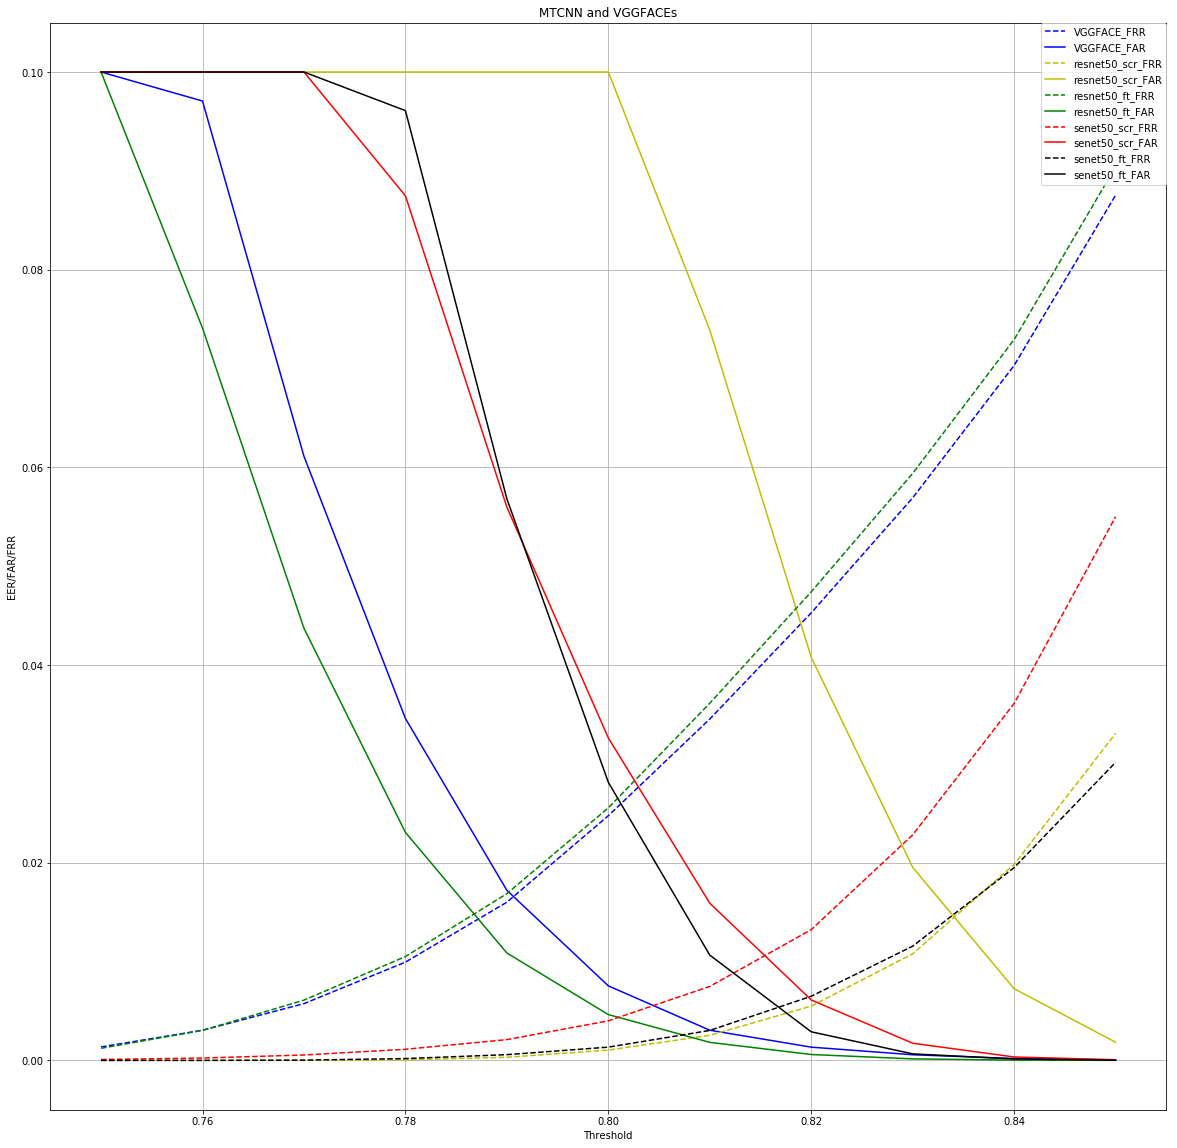

In [25]:
import matplotlib.pyplot as plt
import numpy as np

### ================================ KERAS VGG FACE ================================ ##

VGG_show = np.array([[1.42977648e-01, 1.36054422e-03],
                    [9.70626822e-02, 3.04761905e-03],
                    [6.11205053e-02, 5.74149660e-03],
                    [3.45947522e-02, 9.93877551e-03],
                    [1.72065112e-02, 1.60068027e-02],
                    [7.53935860e-03, 2.47551020e-02],
                    [3.05053450e-03, 3.45374150e-02],
                    [1.33916424e-03, 4.52789116e-02],
                    [5.68999028e-04, 5.69183673e-02],
                    [1.89504373e-04, 7.03129252e-02],
                    [4.32458698e-05, 8.75442177e-02]])

VGG_ROC = np.array([[x[0], x[1]] for x in VGG_show])
VGG_FRR = VGG_ROC[:, 1]
VGG_FAR = VGG_ROC[:, 0]
VGG_FAR = VGG_FAR.clip(max=0.1)

thres = np.array(np.arange(0.75, 0.86, 0.01))

plt.figure(figsize=(20,20))

plt.plot(thres, VGG_FRR,  label='VGGFACE_FRR', color = 'b', linestyle = "--")
plt.plot(thres, VGG_FAR,  label='VGGFACE_FAR', color = 'b')

### =========================== resnet50_scr =========================== ###
resnet50_scr_show = np.array([[0.56836686103, 0.0],
                              [0.452385811467, 0.0],
                              [0.343472789116, 6.80272108844e-06],
                              [0.254477162293, 5.44217687075e-05],
                              [0.182196793003, 0.000312925170068],
                              [0.121736151603, 0.00104081632653],
                              [0.0738999028183, 0.00253741496599],
                              [0.0407823129252, 0.00548979591837],
                              [0.0195281827017, 0.0107823129252],
                              [0.00725315840622, 0.0198299319728],
                              [0.00183624878523, 0.0330816326531]])

resnet50_scr_ROC = np.array([[x[0], x[1]] for x in resnet50_scr_show])
resnet50_scr_FRR = resnet50_scr_ROC[:, 1]
resnet50_scr_FAR = resnet50_scr_ROC[:, 0]
resnet50_scr_FAR = resnet50_scr_FAR.clip(max=0.1)

plt.plot(thres, resnet50_scr_FRR,  label='resnet50_scr_FRR', color = 'y', linestyle = "--")
plt.plot(thres, resnet50_scr_FAR,  label='resnet50_scr_FAR', color = 'y')

### =========================== resnet50_ft =========================== ###
resnet50_ft_show = np.array([[0.114295432459, 0.00122448979592],
                             [0.0740918367347, 0.00303401360544],
                             [0.0437206025267, 0.00609523809524],
                             [0.0230665694849, 0.0105034013605],
                             [0.0108654033042, 0.0168707482993],
                             [0.00463556851312, 0.0255510204082],
                             [0.00182361516035, 0.0361360544218],
                             [0.000593780369291, 0.0474081632653],
                             [0.000151603498542, 0.059387755102],
                             [2.86686103013e-05, 0.0729319727891],
                             [2.91545189504e-06, 0.0904081632653]])

resnet50_ft_ROC = np.array([[x[0], x[1]] for x in resnet50_ft_show])
resnet50_ft_FRR = resnet50_ft_ROC[:, 1]
resnet50_ft_FAR = resnet50_ft_ROC[:, 0]
resnet50_ft_FAR = resnet50_ft_FAR.clip(max=0.1)

plt.plot(thres, resnet50_ft_FRR,  label='resnet50_ft_FRR', color = 'g', linestyle = "--")
plt.plot(thres, resnet50_ft_FAR,  label='resnet50_ft_FAR', color = 'g')

### =========================== senet50_scr =========================== ###
senet50_scr_show = np.array([[0.24693537415, 8.84353741497e-05],
                             [0.182843051506, 0.000238095238095],
                             [0.129871234208, 0.000544217687075],
                             [0.087472303207, 0.00112244897959],
                             [0.0559747327502, 0.00210204081633],
                             [0.0326243926142, 0.004],
                             [0.0158999028183, 0.00748299319728],
                             [0.00611273080661, 0.013231292517],
                             [0.0017351797862, 0.0228163265306],
                             [0.000344509232264, 0.0361156462585],
                             [6.46258503401e-05, 0.0550068027211]])

senet50_scr_ROC = np.array([[x[0], x[1]] for x in senet50_scr_show])
senet50_scr_FRR = senet50_scr_ROC[:, 1]
senet50_scr_FAR = senet50_scr_ROC[:, 0]
senet50_scr_FAR = senet50_scr_FAR.clip(max=0.1)

plt.plot(thres, senet50_scr_FRR,  label='senet50_scr_FRR', color = 'r', linestyle = "--")
plt.plot(thres, senet50_scr_FAR,  label='senet50_scr_FAR', color = 'r')

### =========================== senet50_ft =========================== ###
senet50_ft_show = np.array([[0.264894557823, 0.0],
                            [0.195716229349, 0.0],
                            [0.141659378037, 2.72108843537e-05],
                            [0.0960937803693, 0.000183673469388],
                            [0.0568182701652, 0.000578231292517],
                            [0.0281345966958, 0.00134013605442],
                            [0.0106501457726, 0.00302721088435],
                            [0.00289261418853, 0.00648979591837],
                            [0.000659863945578, 0.0115578231293],
                            [0.000143343051506, 0.0195034013605],
                            [1.89504373178e-05, 0.030156462585]])

senet50_ft_ROC = np.array([[x[0], x[1]] for x in senet50_ft_show])
senet50_ft_FRR = senet50_ft_ROC[:, 1]
senet50_ft_FAR = senet50_ft_ROC[:, 0]
senet50_ft_FAR = senet50_ft_FAR.clip(max=0.1)

plt.plot(thres, senet50_ft_FRR,  label='senet50_ft_FRR', color = 'k', linestyle = "--")
plt.plot(thres, senet50_ft_FAR,  label='senet50_ft_FAR', color = 'k')

### =========================== SHOW ============================ ###
plt.grid(True)
plt.legend(bbox_to_anchor=(1.0,1),loc=1,borderaxespad=0.)


plt.ylabel('EER/FAR/FRR')
plt.xlabel('Threshold')
plt.title("MTCNN and VGGFACEs")
plt.show()